This code implements KSVD algorithm. It was done on google colab.

In [ ]:
import cv2
import numpy as np
import matplotlib.pylab as plt
from time import time
from copy import deepcopy
from numpy.linalg import pinv
from scipy.sparse.linalg import svds
from numpy.linalg import svd

np.random.seed(2000)

In [ ]:
# Using DCT,we generate intial dictionary

def generate_initial_dictionary(num_atoms, block_size):

    num_rows = int(np.ceil(np.sqrt(num_atoms)))
    dictionary = np.zeros((block_size, num_rows))

    for i in range(num_rows):
        basis_vector = np.cos(np.arange(block_size) * i * np.pi / num_rows)
        if i > 0:
            basis_vector = basis_vector - np.mean(basis_vector)

        dictionary[:, i] = basis_vector / np.linalg.norm(basis_vector)

    dictionary = np.kron(dictionary, dictionary)

    initial_dictionary = dictionary[:, :num_atoms]

    return initial_dictionary

In [ ]:
def image_to_columns(image_array, block_size):

    image_height, image_width = image_array.shape
    block_height, block_width = block_size

    # Calculate the number of rows and columns in the result array
    block_rows = block_height
    num_cols = image_height - block_height + 1
    num_rows = image_width - block_width + 1

    # Create indices for rows and columns
    col_indices = np.reshape(range(block_rows), (-1, 1))
    row_indices = np.reshape(range(1, num_cols + 1), (1, -1))
    subs = col_indices + row_indices

    subs_flat = np.zeros((block_rows * block_width, num_cols))
    rows = np.array(range(block_rows))

    for i in range(block_width):
        subs_flat[i * block_rows + rows, :] = subs + image_height * i

    # Create the final indices for the result array
    result_indices = np.zeros((block_rows * block_width, num_cols * num_rows), dtype=int)
    cols = np.array(range(num_cols))

    for j in range(num_rows):
        result_indices[:, j * num_cols + cols] = subs_flat + image_height * j

    result_array = np.zeros((result_indices.shape[0], result_indices.shape[1]))
    # Fill the result array using the indices
    for i in range(result_indices.shape[0]):
        result_array[i, :] = deepcopy(
            image_array[np.unravel_index(result_indices[i, :] - 1, image_array.shape, order='F')]
        )

    return result_array

In [ ]:
def sparse_coding(dict_mat, signals, max_rep_error):
    """
    Sparse coding of a group of signals based on a given dictionary and specified number of atoms to use.

    Parameters:
    - dict_mat : The dictionary matrix.
    - signals : The signals to be represented.
    - max_rep_error : The maximal allowed representation error for each signal.

    Returns:
    - coff_mat : Sparse coefficient matrix.
    """
    num_atoms, num_sigs = dict_mat.shape[1], signals.shape[1]
    num_feats, num_atoms_dict = signals.shape[0], dict_mat.shape[0]

    coff_mat = np.zeros((num_atoms, num_sigs))
    max_sq_error = (max_rep_error**2) * num_feats

    max_num_coeffs = num_feats // 2

    for sig_idx in range(num_sigs):
        cur_coff = 0
        cur_sig = deepcopy(signals[:, sig_idx])
        cur_residual = deepcopy(cur_sig)
        selected_indices = np.array([], dtype=int)

        cur_residual_norm_sq = np.sum(cur_residual**2)
        num_selected_coeffs = 0

        while cur_residual_norm_sq > max_sq_error and num_selected_coeffs < max_num_coeffs:
            num_selected_coeffs += 1
            # Project the residual onto the dictionary
            projections = np.dot(dict_mat.T, cur_residual)

            selected_index = np.argmax(np.abs(projections))
            selected_indices = np.append(selected_indices, int(selected_index))

            # Update coefficients using pseudo-inverse
            cur_coff = np.dot(pinv(dict_mat[:, selected_indices[0:num_selected_coeffs]]), cur_sig)
            cur_residual = cur_sig - np.dot(dict_mat[:, selected_indices[0:num_selected_coeffs]], cur_coff)
            cur_residual_norm_sq = np.sum(cur_residual**2)

        # Update the coefficients matrix for the current signal
        if len(selected_indices) > 0:
            coff_mat[selected_indices, sig_idx] = deepcopy(cur_coff)

    return coff_mat

In [ ]:
def ksvd_dict_update(data, dict_mat, coff_mat):
    """
    Update the dictionary using the K-SVD algorithm for Dictionary Learning.

    Parameters:
    - data : Input images.
    - dict_mat : Dictionary to be updated.
    - coff_mat: Coefficient matrix obtained from sparse coding.

    Returns:
    - updated_dict (numpy.ndarray): Updated dictionary.
    - updated_coff (numpy.ndarray): Updated coefficient matrix.
    """
    updated_dict = deepcopy(dict_mat)
    updated_coff = deepcopy(coff_mat)

    atom_indices = np.random.permutation(updated_dict.shape[1])

    for atom_idx in atom_indices:
        # Find indices of data points that use the current dictionary element
        relevant_data_indices = np.nonzero(updated_coff[atom_idx, :])[0]

        if len(relevant_data_indices) < 1:
            # If no data points use the current atom, replace it with the best-matching data point
            error_matrix = data - np.dot(updated_dict, updated_coff)
            error_norm_vector = np.sum(error_matrix**2, axis=0)
            max_error, max_error_index = np.max(error_norm_vector), np.argmax(error_norm_vector)
            better_dict_elem = deepcopy(data[:, max_error_index])

            better_dict_elem /= np.sqrt(np.dot(better_dict_elem.T, better_dict_elem))
            better_dict_elem *= np.sign(better_dict_elem[0])

            # Update coefficients matrix and dictionary
            updated_coff[atom_idx, :] = np.zeros((updated_coff.shape[1],))
            updated_dict[:, atom_idx] = deepcopy(np.reshape(better_dict_elem, (-1,)))

            return updated_dict, updated_coff

        relevant_coff = deepcopy(updated_coff[:, relevant_data_indices])
        relevant_coff[atom_idx, :] = np.zeros((relevant_coff.shape[1]))

        # Calculate errors for the relevant data points
        errors = data[:, relevant_data_indices] - np.dot(updated_dict, relevant_coff)

        # Perform singular value decomposition (SVD) to find the better dictionary element
        uu, ss, vv = svd(errors)
        better_dict_elem, singular_value, beta_vector = uu[:, 0], ss[0], vv[0, :]

        # Update the coefficients matrix and dictionary
        updated_coff[atom_idx, relevant_data_indices] = np.dot(singular_value, beta_vector)
        updated_dict[:, atom_idx] = deepcopy(np.reshape(better_dict_elem, (-1,)))

    return updated_dict, updated_coff

In [ ]:
# Combining sparse coding and ksvd dictionary learning
def ksvd(data, init_dict, itN, error_goal):

    learned_dict = deepcopy(init_dict)
    iterations = itN
    error_global = error_goal

    for _ in range(iterations):
        coff_mat = sparse_coding(learned_dict, data, error_global)
        learned_dict, coff_mat = ksvd_dict_update(data, learned_dict, coff_mat)

    return learned_dict

In [ ]:
def denoise_image(image, num_atoms=256, noise_level=25):
    # Parameters
    noise_sigma = noise_level
    num_atoms_val = num_atoms
    image_height, image_width = image.shape
    c = 1.15
    block_size = 8
    max_num_blocks_to_train_on = 1000
    num_iters = 15
    error_goal = noise_sigma * c

    # Train a dictionary on blocks from the noisy image
    if np.prod(np.array([image_height, image_width]) - block_size + 1) > max_num_blocks_to_train_on:
        rand_permutation = np.random.permutation(np.prod(np.array([image_height, image_width]) - block_size + 1))
        selected_blocks = rand_permutation[:max_num_blocks_to_train_on]
        block_matrix = np.zeros((block_size ** 2, max_num_blocks_to_train_on))
        for i in range(max_num_blocks_to_train_on):
            row, col = np.unravel_index(selected_blocks[i], tuple(np.array(image.shape) - block_size + 1), order='F')
            curr_block = image[row:row + block_size, col:col + block_size]
            block_matrix[:, i] = np.reshape(curr_block, (-1,), order='F')
    else:
        block_matrix = image_to_columns(image, (block_size, block_size))

    # Make initial dictionary from DCT
    initial_dictionary = generate_initial_dictionary(num_atoms_val, block_size)

    vec_of_means = np.mean(block_matrix, axis=0)
    block_matrix = block_matrix - np.dot(np.ones((block_matrix.shape[0], 1)), np.reshape(vec_of_means, (1, -1), order='F'))

    print('Denoising using KSVD')
    dictionary = ksvd(block_matrix, initial_dictionary, num_iters, error_goal)

    # Denoise the image using the resulting dictionary
    error_threshold = noise_sigma * c
    blocks = image_to_columns(image, (block_size, block_size))
    idx = range(blocks.shape[1])

    for iters in range(0, blocks.shape[1], 30000):
        jump_size = min(iters + 30000, blocks.shape[1])
        vec_of_means = np.mean(blocks[:, iters:jump_size], axis=0)
        blocks[:, iters:jump_size] = blocks[:, iters:jump_size] - np.tile(vec_of_means, (blocks.shape[0], 1))
        coefs = sparse_coding(dictionary, blocks[:, iters:jump_size], error_threshold)
        blocks[:, iters:jump_size] = np.dot(dictionary, coefs) + \
                                  np.dot(np.ones((blocks.shape[0], 1)), np.reshape(vec_of_means, (1, -1), order='F'))

    count = 0
    weight = np.zeros((image_height, image_width))
    im_out = np.zeros((image_height, image_width))
    rows, cols = np.unravel_index(idx, tuple(np.array(image.shape) - block_size + 1), order='F')

    for i in range(len(cols)):
        col = cols[i]
        row = rows[i]
        block = np.reshape(blocks[:, count], (block_size, block_size), order='F')
        im_out[row:row+block_size, col:col+block_size] += block
        weight[row:row+block_size, col:col+block_size] += np.ones((block_size, block_size))
        count += 1

    # Final denoised image
    denoised_image = (image + 0.034 * noise_sigma * im_out) / (1.0 + 0.034 * noise_sigma * weight)
    return denoised_image


Denoising using KSVD


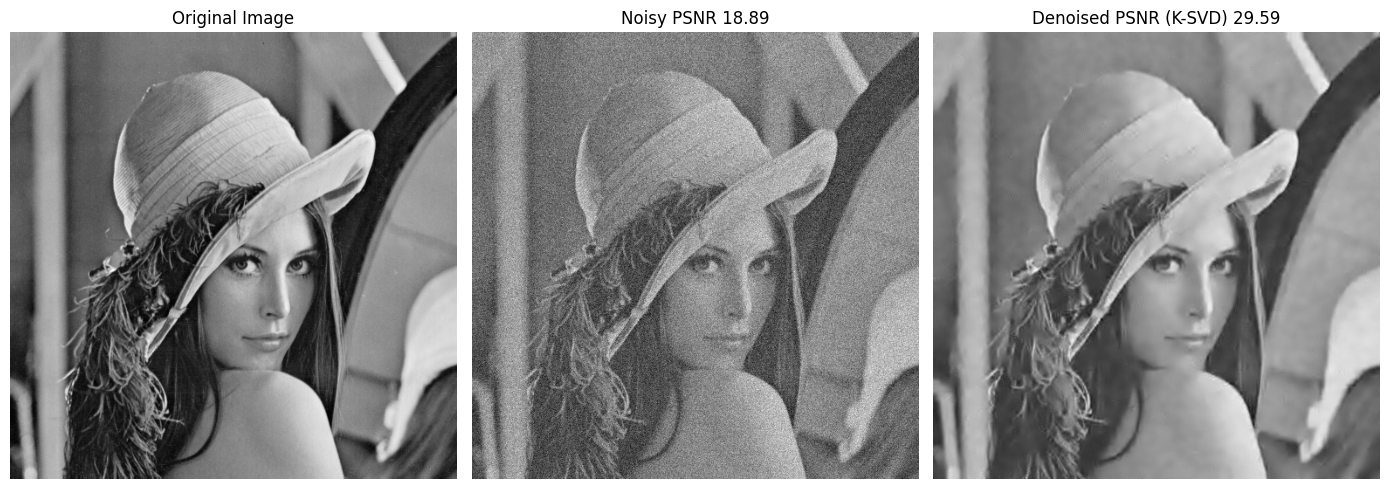

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

k = 256
sigma = 25

img = cv2.imread('lena512.bmp',0)
original_image = np.float64(img)

# Add Gaussian noise to the original image
noised_image = original_image + sigma * np.random.standard_normal(original_image.shape)

# Denoise the corrupted image using the learned dictionary
denoised_image = denoise_image(noised_image, num_atoms=k, noise_level=sigma)

# Calculate PSNR for the noisy and denoised images
noised_psnr = psnr(original_image, noised_image, data_range=original_image.max() - original_image.min())
denoised_psnr = psnr(original_image, denoised_image, data_range=original_image.max() - original_image.min())

# Display the results
plt.close('all')
plt.figure(figsize=(14, 10))

plt.subplot(131)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noised_image, cmap='gray')
plt.title(f'Noisy PSNR {noised_psnr:.2f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'Denoised PSNR (K-SVD) {denoised_psnr:.2f}')
plt.axis('off')

plt.tight_layout()

plt.show()


Denoising using KSVD


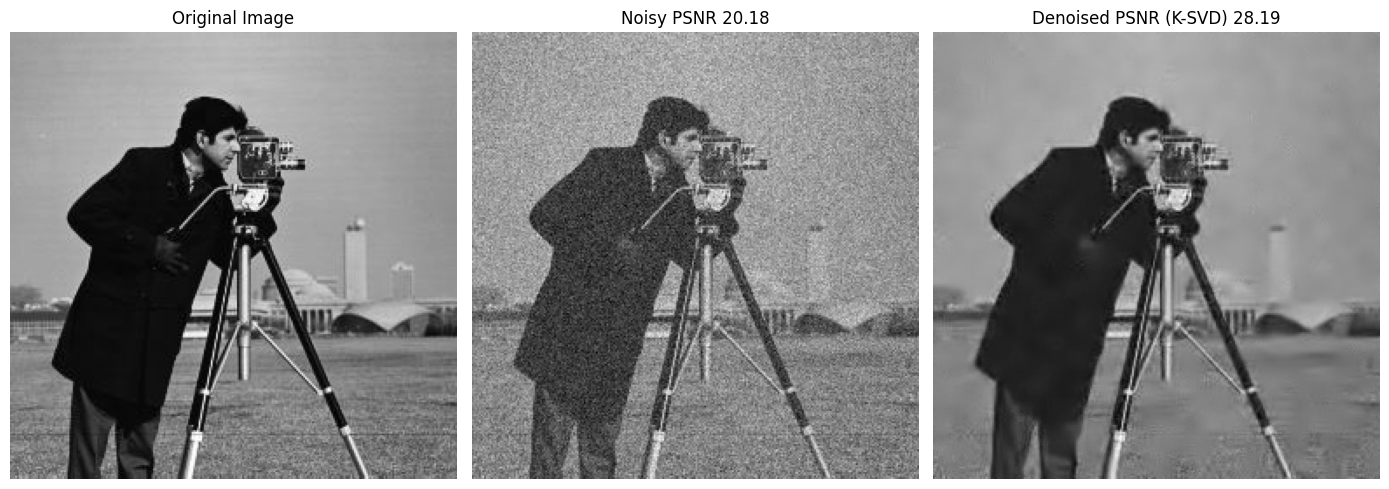

In [ ]:
img = cv2.imread('cameraman.jpg',0)
original_image = np.float64(img)

# Add Gaussian noise to the original image
noised_image = original_image + sigma * np.random.standard_normal(original_image.shape)

# Denoise the corrupted image using the learned dictionary
denoised_image = denoise_image(noised_image, num_atoms=k, noise_level=sigma)

# Calculate PSNR for the noisy and denoised images
noised_psnr = psnr(original_image, noised_image, data_range=original_image.max() - original_image.min())
denoised_psnr = psnr(original_image, denoised_image, data_range=original_image.max() - original_image.min())

# Display the results
plt.close('all')
plt.figure(figsize=(14, 10))

plt.subplot(131)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noised_image, cmap='gray')
plt.title(f'Noisy PSNR {noised_psnr:.2f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'Denoised PSNR (K-SVD) {denoised_psnr:.2f}')
plt.axis('off')
plt.tight_layout()
plt.show()


Denoising using KSVD


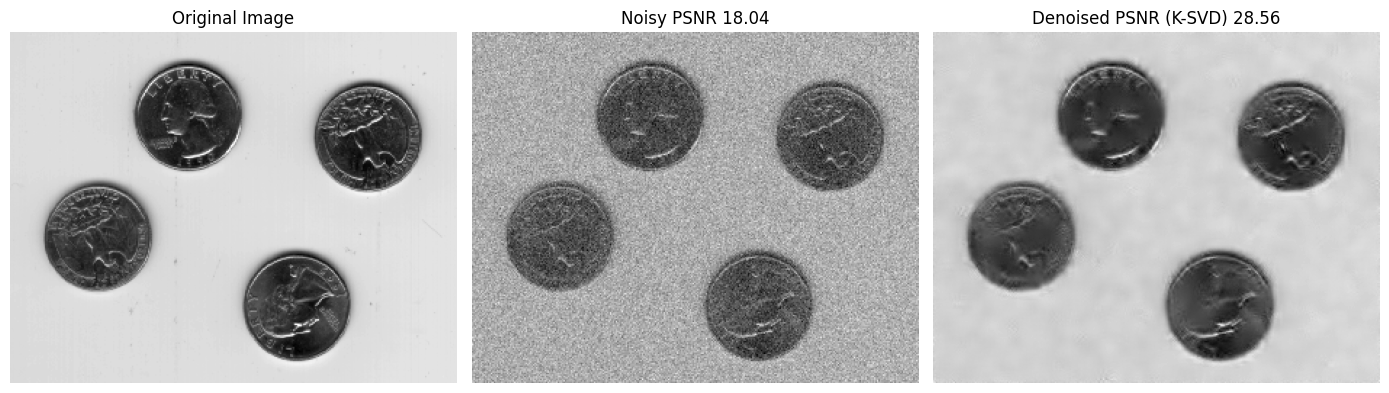

In [ ]:
img = cv2.imread('eight.tif',0)
original_image = np.float64(img)

# Add Gaussian noise to the original image
noised_image = original_image + sigma * np.random.standard_normal(original_image.shape)

# Denoise the corrupted image using the learned dictionary
denoised_image = denoise_image(noised_image, num_atoms=k, noise_level=sigma)

# Calculate PSNR for the noisy and denoised images
noised_psnr = psnr(original_image, noised_image, data_range=original_image.max() - original_image.min())
denoised_psnr = psnr(original_image, denoised_image, data_range=original_image.max() - original_image.min())

# Display the results
plt.close('all')
plt.figure(figsize=(14, 10))

plt.subplot(131)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noised_image, cmap='gray')
plt.title(f'Noisy PSNR {noised_psnr:.2f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'Denoised PSNR (K-SVD) {denoised_psnr:.2f}')
plt.axis('off')
plt.tight_layout()
plt.show()
